# Lab 3 - Metrics and scores
In this lab, you will code a set of metrics to be able to evaluate yourself your model, then you compare the performances to a model loaded from hugging face.

You will need the ```dataset.py``` file from Lab 1 and the dataset used in Lab 1, as well as the `models.py` from Lab 2 with the weights of your pretrained model from Lab 2.

Good testing is reproducable. And what better solution than using a dataset that is the same for everyone? 
For this, we will use the voxceleb1 original test split and the list of trials that comes with it.

The dataset can be downloaded here (~1.7Gb): [voxceleb1_test_original](https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/tthebau1_jh_edu/IQCT4Lzrd4c_Tqbi6bOmq79BAegCBhYv6p5Nje698V3zimk?e=dXMPIM)

Start the download now, you will need it for Part 2

## Part 1: Metrics on the validation set
In this first question, you will load a previously trained model (from Lab 2) and compute a set of metrics on the validation set.

### Question 1 (5pts): Loading the train and validation
Modify your `load_all_data` function into a `load_val_train` to split voxceleb2-dev-AE only in 2 sets: train and validation. 

In [1]:
from dataset import load_val_train
val_loader, train_loader = load_val_train(
                                metadata_file="VoxCeleb2_AE/metadata_dev.csv", 
                                data_directory="VoxCeleb2_AE/dev", 
                                batch_size=32,
                                train_val_prop=0.9,
                                speaker_subset=100
                                )

Total speakers: 1094
Limitation of the number of speakers for faster training: using 100 speakers
Selected subset of speakers: 100
Train/Val speakers: 100/95
Train/Val Datasets: 2130/251


### Question 2 (5pts): Embedding extraction
Load your xvector model from last week and extract the embeddings from the validation loader

_A subset of the embeddings is enough, extraction takes time_

In [2]:
# Get validation embeddings
import os
from models import XVector
import torch
from tqdm import tqdm


all_embeddings = []
all_labels = []
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = XVector(num_speakers=100, embedding_dim=64)
    model.load_state_dict(torch.load("models/xvector_epoch8.pt", map_location=device))
    model.to(device)
    model.eval()
    for i, (x, y, _, _) in enumerate(tqdm(val_loader)):
        x = x.to(device)
        y = y.to(device)
        
        h = model.tdnn1(x)
        h = model.tdnn2(h)
        h = model.tdnn3(h)
        h = model.tdnn4(h)
        h = model.tdnn5(h)
        
        mean = h.mean(dim=1)
        std = h.std(dim=1, unbiased=False)
        stats = torch.cat([mean, std], dim=1)
        
        emb = model.seg_fc1(stats)
        emb = model.relu(emb)
        emb = model.seg_fc2(emb)
        emb = model.relu(emb)
        
        all_embeddings.append(emb.cpu())
        all_labels.append(y.cpu())   
    

# Concatenate all embeddings and labels
all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()
print("Embeddings shape:", all_embeddings.shape)

/var/folders/2_/hh831c2x7tng_47gpsqfj6l00000gn/T/ipykernel_3230/3085006221.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/xvec

Embeddings shape: (251, 64)


### Question 3 (10pts): Cosine scoring
In this question, create a `metrics.py` that will contain the additional functions you will create for this lab.
Create a `cosine_scoring_all(embeddings, labels)` that:
1. Takes embeddings matrix (N,D) and the references of speakers (N,)
2. Normalize all embeddings (L2 norm = 1)
3. Score all embeddings against each others, giving a (N,N) score matrix with 1 in the diagonal
4. Returns a list of cosine scores and a list of binary labels (target or non-target) depending on if the pairs of utterances were from the same speaker or not. 

_Note: We do not use the diagonal, so both list should be of length (N^2 - N)_

In [3]:
from metrics import cosine_scoring_all
import numpy as np
scores, targets = cosine_scoring_all(all_embeddings, all_labels)
scores = np.array(scores)
targets = np.array(targets)
print(scores.shape, targets.shape)

(62750,) (62750,)


### Question 4 (10pts): Show the distribution
Use `matplotlib.pyplot.hist`to print the distributions of the target scores and the non-target scores.

Do you think your model trained enough to be able to distinguish the same speaker from different speaker?

(Optional) If not, you can use a pretrain model and try again, such as this one: [Speechbrain ECAPA-TDNN](https://huggingface.co/speechbrain/spkrec-ecapa-voxceleb)

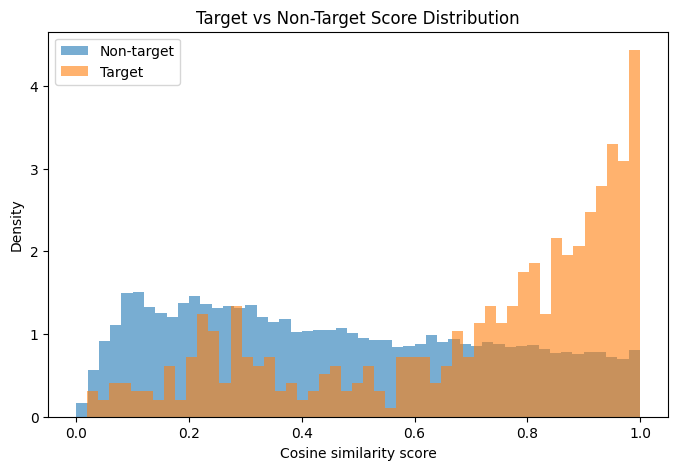

In [4]:
import numpy as np
import matplotlib.pyplot as plt

target_scores = scores[targets == 1]
nontarget_scores = scores[targets == 0]

plt.figure(figsize=(8,5))

plt.hist(nontarget_scores, bins=50, alpha=0.6, density=True, label="Non-target")
plt.hist(target_scores, bins=50, alpha=0.6, density=True, label="Target")

plt.xlabel("Cosine similarity score")
plt.ylabel("Density")
plt.title("Target vs Non-Target Score Distribution")
plt.legend()


plt.show()

### Question 5 (20pts): False Acceptation Rate, False Rejection Rate and Equal Error Rate
Let's start computing metrics! 
- [5pts] First, create a `FAR_FRR(scores, targets, threshold)` function in `metrics.py`, which for a given threshold returns the False Acceptation Rate and the False Rejection Rate
- [5pts] Second, create a `FAR_FRR_all(scores, targets, N=1000)` function in `metrics.py`, which returns lists of all the FAR and FRR given N different thresholds between 0 and 1
- [5pts] Third, create a `EER(scores, targets)` function in `metrics.py`, which returns the value of the EER, and the corresponding threshold. By definition, the EER is the value that minimize the difference between FAR and FRR

[5pts] Then, show that the three functions are working by:
1. Printing the value of `FAR_FRR(scores, targets, threshold=0.5)`
1. Ploting the curve of all FAR vs all FRR using `matplotlib.pyplot.plot`
3. Printing the value of `EER(scores, targets)`

Threshold = 0.5 → FAR = 0.424, FRR = 0.251


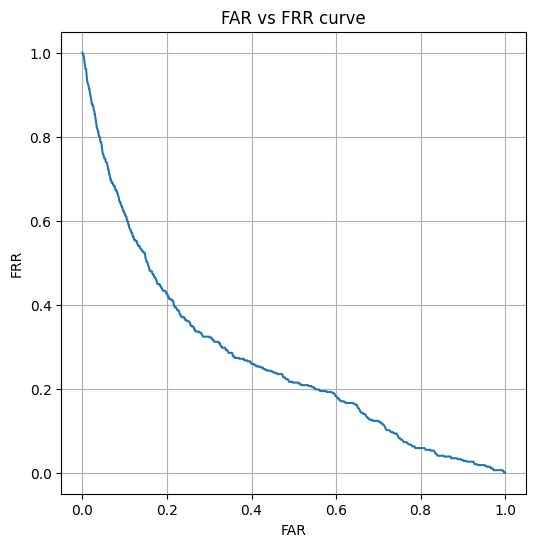

EER = 31.17% at threshold = 0.6244


In [5]:
from metrics import FAR_FRR, FAR_FRR_all, EER

# Print single threshold result
far, frr = FAR_FRR(scores, targets, threshold=0.5)
print(f"Threshold = 0.5 → FAR = {far:.3f}, FRR = {frr:.3f}")

# Plot the full FAR-FRR curve
import matplotlib.pyplot as plt

thresholds, FARs, FRRs = FAR_FRR_all(scores, targets, N=1000)

plt.figure(figsize=(6,6))
plt.plot(FARs, FRRs)
plt.xlabel("FAR")
plt.ylabel("FRR")
plt.title("FAR vs FRR curve")
plt.grid(True)
plt.show()

# Print the Equal Error Rate
eer, thr = EER(scores, targets)
print(f"EER = {100*eer:.2f}% at threshold = {thr:.4f}")

#### Checking the time
Now, you may say this computation could add a significant time to the training if we had to measure that for every epoch. 

To verify if your function is fast enough, run the following block. The expected time should be under 500ms.

In [6]:
import time
start_time = time.time()
scores, targets = cosine_scoring_all(all_embeddings, all_labels)
eer, thr = EER(scores, targets)
elapsed = time.time() - start_time

print(f"Time to compute the EER: {1000*elapsed:.1f}ms")

Time to compute the EER: 7.9ms


## Part II: Metrics on VoxCeleb1
In this section, you will import this testing dataset, and the associated list of trials, and compute the official score of your network.
Then, you will load a pretrained model, and show that you can measure the EER as it is declared in the associated publication.
Hopefully, you have now downloaded voxceleb1 test set! 

_For time purposes, I only gave you the files for the original split, which is the smallest. You can obtain the extended and hard splits online, or I can send them on demand, but they are significantly bigger._

### Question 6 (10pts): Dataloading
The Dataloading of the test set will be a bit different than previously.
In the `dataset.py` file, implement a `load_test(metadata_file, data_directory, trials_files)` function that
1. Loads the test set based on your `My_Dataset` class, with no minimum or maximum length (using the whole utterance every time), batch size of 1, using:
    - `metadata_file='../voxceleb1_test_original/metadata_test.csv'`
    - `data_directory='../voxceleb1_test_original/wav'`
2. Loads the trial file, return a dictionnary with the trial file . Given the input:
    - `trial_file='../voxceleb1_test_original/trials_o.csv'`
    - returns a pandas.DataFrame for each trial list

_Warning: This dataset does not contain age labels, you will have to either modify your Dataset class, or input a random age in the metadata._

In [7]:
from dataset import load_test
test_loader, trials = load_test(
                            metadata_file='voxceleb1_test_original_full/voxceleb1_test_original/metadata_test_o.csv', 
                            data_directory='voxceleb1_test_original_full/voxceleb1_test_original/wav_original',
                            trial_file='voxceleb1_test_original_full/voxceleb1_test_original/trials_o.csv'
                            )
print(f"Test set loaded: {len(test_loader)} files, with trial file: O {trials.shape}")

Total speakers: 100
Test set loaded: 8634 files, with trial file: O (15924, 3)


### Question 7 (10pts): Extract the test embeddings
Similar to question 2, extract the test embeddings, and their associated ids.

_Warning: your current dataset outputs waveforms, speaker_ids, ages, genders, but **not the id of the utterance**, which is a string type. this may be slighlty more tricky than expected!_

In [8]:
test_embeddings = []
test_utt = []
device='cpu'

with torch.no_grad():
    for i, (x, y, _, _) in enumerate(tqdm(test_loader, desc="Test emb extraction")):
        x = x.to(device)

        # ----- forward up to embeddings (same as you did for val) -----
        h = model.tdnn1(x)
        h = model.tdnn2(h)
        h = model.tdnn3(h)
        h = model.tdnn4(h)
        h = model.tdnn5(h)

        mean = h.mean(dim=1)
        std = h.std(dim=1, unbiased=False)
        stats = torch.cat([mean, std], dim=1)

        emb = model.seg_fc1(stats)
        emb = model.relu(emb)
        emb = model.seg_fc2(emb)
        emb = model.relu(emb)

        test_embeddings.append(emb.cpu())

        # ----- get utterance id string from dataframe -----
        utt_id = test_loader.dataset.df.iloc[i]["id"]
        test_utt.append(utt_id)

# Concatenate all embeddings and labels
test_embeddings = torch.cat(test_embeddings, dim=0).numpy()
test_utt = np.array(test_utt)
print("Embeddings shape:", test_embeddings.shape, "utt_id shape:", test_utt.shape)
print(f"First 3 ids: {test_utt[:3]}")

Test emb extraction: 100%|██████████████████| 8634/8634 [01:40<00:00, 86.10it/s]

Embeddings shape: (8634, 64) utt_id shape: (8634,)
First 3 ids: ['id10001-1zcIwhmdeo4-00001' 'id10001-1zcIwhmdeo4-00002'
 'id10001-1zcIwhmdeo4-00003']


#### Quick helper code, as computing the embeddings takes time:
Saving and Loading the embeddings

In [9]:
# SAVING
MY_EMB_DIR = 'my_test_embeddings'
# Create a new directory
os.makedirs(f"{MY_EMB_DIR}", exist_ok=True)
# Save the arrays as .npy files in the directory
np.save(f"{MY_EMB_DIR}/test_utt.npy", test_utt)
np.save(f"{MY_EMB_DIR}/test_embeddings.npy", test_embeddings)
print(f"Embeddings saved in directory {MY_EMB_DIR}")

Embeddings saved in directory my_test_embeddings


In [10]:
# LOADING
import numpy as np
# Loads the arrays from the directory
test_utt = np.load(f"{MY_EMB_DIR}/test_utt.npy")
test_embeddings = np.load(f"{MY_EMB_DIR}/test_embeddings.npy")
print("Embeddings Loaded:", test_embeddings.shape, test_utt.shape)


Embeddings Loaded: (8634, 64) (8634,)


### Question 8 (20pts): Cosine scoring on trials
Taking inspiration from your function `cosine_scoring_all`, in `metrics.py`, create a function `cosine_scoring_from_trials(test_embeddings, test_utt, trials_df)` that takes the extracted embeddings, the dataframe of trials, and returns the score for each trial in the list.

Score your embeddings for the trials O, E and H.

Print the EER for each split

In [11]:
from metrics import EER, cosine_scoring_from_trials

scores, targets = cosine_scoring_from_trials(test_embeddings, test_utt, trials.copy())
eer, thr = EER(scores, targets)
print(f"EER Vox1-O = {100*eer:.2f}%")

EER Vox1-O = 50.80%


### Question 9 (10pts) Read and compare
Fill the following Markdown table with your results, then compare with 3 existing models, described in the following papers:

1. ECAPA-TDNN [https://arxiv.org/pdf/2005.07143]
2. ResNet50 [https://arxiv.org/pdf/1806.05622]
3. Res2Net [https://arxiv.org/pdf/2007.02480]

Then put the results in the Table.

Explain what might be the differences between your model and others, by adding up to 3 columns to the table.

| Model        | EER Vox1-O | EER Vox1-E | EER Vox1-H | ModelSize | TrainingData        | Architecture |
|--------------|------------|------------|------------|---------- |----------------------|--------------------------|
| My Model     | 50.80%     | —          | —          | 2.87M      | VoxCeleb2-AE dev (100 speakers)  | TDNN (X-vector) |
| ECAPA-TDNN   | 0.87%      | 1.12%      | 2.12%      | 14.7M     | Full VoxCeleb2       | TDNN + SE blocks + Res2 + AAM-Softmax |
| ResNet50     | 3.95%      | 4.42%      | 7.33%      | 25M+      | Full VoxCeleb2       | Deep 50-layer CNN with residual blocks |
| Res2Net      | 1.45%      | 1.47%      | 2.72%      | 9.3M      | Full VoxCeleb2       | Multi-scale residual CNN |


My model performs much worse than ECAPA TDNN, ResNet50, and Res2Net mainly because it is much smaller and trained on far less data. I trained my model using only 100 speakers, while those published models were trained on thousands of speakers from the full VoxCeleb dataset, which helps them learn stronger and more general speaker patterns. Architecturally, my model is a simple X vector TDNN with basic mean and standard deviation pooling, while the other models use deeper networks with attention mechanisms and more advanced feature extraction blocks that capture speaker characteristics more effectively. They also use stronger training strategies and better loss functions that improve how well the model separates different speakers. Because of these differences, my model struggles to distinguish speakers properly, which is why its equal error rate is much higher compared to the state of the art systems.